In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [15]:
data_dir = "/Users/esbishop/Sea_snakes_images/Images"   # Path to image directory

In [16]:
# We need to define some parameters for the laoder: 
batch_size = 32
img_height = 180
img_width = 180

In [17]:
# It's good practice to use a validation split when developing a model. Let's use 80% of the images for training, 
# and 20% for validation. 
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1370 files belonging to 2 classes.
Using 1096 files for training.


In [18]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1370 files belonging to 2 classes.
Using 274 files for validation.


In [19]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = "/Users/esbishop/Sea_snakes_images/test_images",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 314 files belonging to 2 classes.


In [20]:
# We can have a look at the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order. 
class_names = train_ds.class_names
print(class_names)

['rope', 'snake']


2022-01-19 14:12:50.593249: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-19 14:12:50.593904: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-19 14:13:00.674053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 245 of 256
2022-01-19 14:13:00.918097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


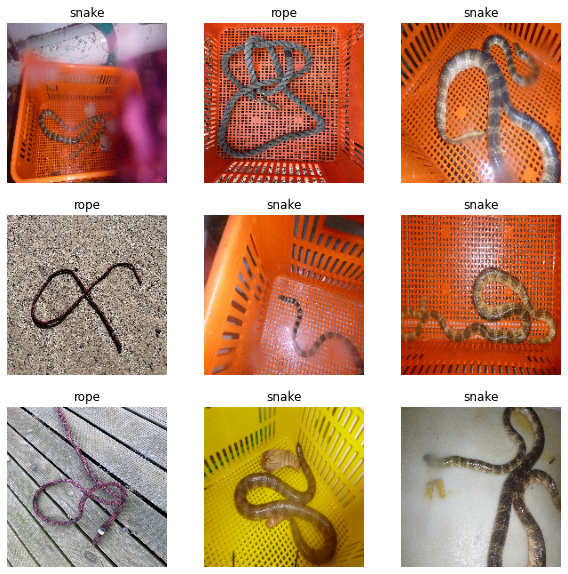

In [8]:
# We can have a look at the first 9 images from the training dataset: 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# We will train a model using these datasets by passing them to Model.fit. We can also manually iterate over the 
# dataset and retreive batches on images:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

### Configure the Dataset for performance

Let's make sure to use buffered prefetching so you can yeild data from disk without haveing I/O become blocking. These are two important methods you should use when loading data: 
- Dataset.cache keeps the images in memory after theyre loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training the model. If your dataset is too large to fit in memory, you can also use this method to create a performant on-disk cache. 
- Dataset.prefetch overlaps data preprocessing and model execution while training.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Feature extraction together with data augmentation

Now we'll try the slower and more expensive option, which allowes us to use data augmentation - creating a model than chains the conv_base to a new dense classifier, and training it end to end on the inputs. 

First we must freeze the covolutional base. Freezing a layer or set of layers means preventing their weights from being updated during training. If we don't do this, the representations that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialised, very large weight updates would be propogated through the network, effectively destroying the representation previously learned. 

In Keras, we freeze a layer or model by setting its trainable attribute to False.

In [8]:
# Instantiating and freezing the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False)
conv_base.trainable = False
# Setting trainable to False empties the list of trainable weights of the layer or model

In [9]:
# Printing the list of trainable weights before and after freezing 
conv_base.trainable = True
print("This is the number of trainable weights "
     "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [10]:
conv_base.trainable = False
print("This is the number of trainable weights "
     "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Now we can create a new model that chains together 
1. A data augmentation stage 
2. Our frozen convolutional base
3. A dense classifier

In [11]:
with tf.device('/CPU:0'):
    data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ])

In [21]:
num_classes = len(class_names)

inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation = "sigmoid")(x)
outputs = layers.Dense(num_classes)(x)
model = keras.Model(inputs, outputs)

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer = "adam", 
             metrics = ["accuracy"])

You need to compile the model after you modify weight trainability, otherwise the changes will not be applied. 

Thanks to data augmentation, it will take much longer for the model to start overfitting, so we can train for more epochs. 

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "feature_extraction_with_data_augmentation.keras",
        save_best_only = True,
        monitor = "val_loss")
]

In [16]:
epochs = 50

history = model.fit(
    train_ds,
    epochs = epochs, 
    validation_data = val_ds,
    callbacks = callbacks)

Epoch 1/50


2022-01-19 14:13:26.443446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-19 14:13:37.908293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-01-19 14:13:46.840775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 8 of 1000
2022-01-19 14:13:57.086197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 16 of 1000
2022-01-19 14:14:07.075849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 24 of 1000
2022-01-19 14:14:09.589773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - ETA: 0s - loss: 0.6990 - accuracy: 0.6569

2022-01-19 14:14:26.748903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 75s 807ms/step - loss: 0.6990 - accuracy: 0.6569 - val_loss: 0.5699 - val_accuracy: 0.8796
Epoch 2/50
35/35 [==============================] - 16s 468ms/step - loss: 0.5931 - accuracy: 0.8513 - val_loss: 0.6181 - val_accuracy: 0.7153
Epoch 3/50
35/35 [==============================] - 16s 466ms/step - loss: 0.6185 - accuracy: 0.7427 - val_loss: 0.5923 - val_accuracy: 0.7774
Epoch 4/50
35/35 [==============================] - 17s 477ms/step - loss: 0.5802 - accuracy: 0.8431 - val_loss: 0.5348 - val_accuracy: 0.9124
Epoch 5/50
35/35 [==============================] - 18s 509ms/step - loss: 0.5687 - accuracy: 0.8695 - val_loss: 0.5577 - val_accuracy: 0.8686
Epoch 6/50
35/35 [==============================] - 17s 494ms/step - loss: 0.5471 - accuracy: 0.8923 - val_loss: 0.5123 - val_accuracy: 0.9197
Epoch 7/50
35/35 [==============================] - 18s 519ms/step - loss: 0.5244 - accuracy: 0.9115 - val_loss: 0.5112 - val_accuracy: 0.9124
Epoch 8/50

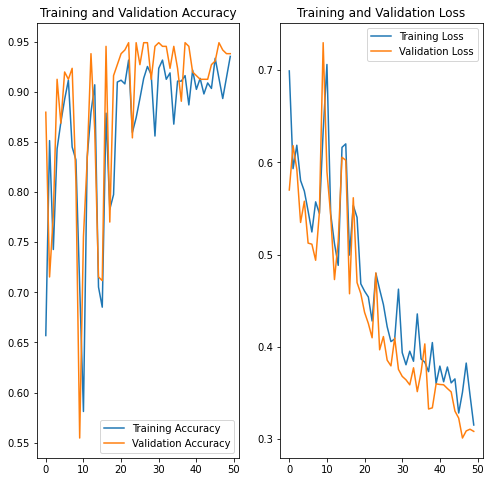

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
# Evaluate the model accuracy on test set 
test_model = keras.models.load_model(
            "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_ds) 
print(f"Test accuracy: {test_acc:.3f}")

2022-01-19 14:58:24.062485: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-19 14:58:24.064733: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-19 14:58:24.065174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 12s 415ms/step - loss: 0.3363 - accuracy: 0.9236
Test accuracy: 0.924


### Fine-tuning a pre-trained model

Fine tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers. This is called fine tuning because it slightly adjusts the more abstract representations of the model being reused in order to make them more relevent for the problem at hand. 

We mentioned earlier that it is necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialised classifier on top. For the same reason, it's only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classifyer isn't already trained, the error signal propogating through the network will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed. Thus the steps for fine-tuning a network are as follows: 
1. Add our custom network on top of an already-trained base network
2. Freeze the base network 
3. Train the part we added 
4. Unfreeze some layers in the base network
5. Jointly train both these layers and the part we added
We have already done the first three steps. So now we need to unfreeze our conv_base and then freeze individual layers inside it. 


We’ll fine-tune the last three convolutional layers, which means all layers up to block4_ pool should be frozen, and the layers block5_conv1, block5_conv2, and block5_conv3 should be trainable.

In [24]:
# Freezing all layers until the fourth from the last 
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False 

Now we can begin fine-tuning the model. We'll do this with the RMSProp optimiser (which allows us to control the learning rate, cf adam which adjusts the learnng rate itself) using a very low learning rate. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the three layers we are fine-tuning. Updates that are too large may harm these representations. 

In [26]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5),
             metrics = ["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "fine_tuning.keras",
        save_best_only = True,
        monitor = "val_loss")
]

epochs = 30

history = model.fit(
    train_ds,
    epochs = epochs,
    validation_data = val_ds,
    callbacks = callbacks)

Epoch 1/30


2022-01-19 15:19:19.364682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.6268

2022-01-19 15:20:09.458467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-19 15:20:19.503242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 249 of 256
2022-01-19 15:20:19.718507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 64s 1s/step - loss: 0.6650 - accuracy: 0.6268 - val_loss: 0.6275 - val_accuracy: 0.7774
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.6241 - accuracy: 0.7591

2022-01-19 15:21:21.624429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 224 of 256
2022-01-19 15:21:23.006021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 63s 2s/step - loss: 0.6241 - accuracy: 0.7591 - val_loss: 0.6034 - val_accuracy: 0.8577
Epoch 3/30


2022-01-19 15:21:37.194750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 201 of 256
2022-01-19 15:21:39.278164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - ETA: 0s - loss: 0.5987 - accuracy: 0.8586

2022-01-19 15:22:35.057403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 197 of 256
2022-01-19 15:22:37.924255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 75s 2s/step - loss: 0.5987 - accuracy: 0.8586 - val_loss: 0.5896 - val_accuracy: 0.9234
Epoch 4/30


2022-01-19 15:22:52.201452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 183 of 256
2022-01-19 15:22:54.835582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - ETA: 0s - loss: 0.5901 - accuracy: 0.8768

2022-01-19 15:23:43.007485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 249 of 256
2022-01-19 15:23:43.220281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 65s 1s/step - loss: 0.5901 - accuracy: 0.8768 - val_loss: 0.5868 - val_accuracy: 0.9234
Epoch 5/30


2022-01-19 15:23:57.114838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 245 of 256
2022-01-19 15:23:57.376655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - ETA: 0s - loss: 0.5830 - accuracy: 0.9015

2022-01-19 15:24:45.339213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 246 of 256
2022-01-19 15:24:45.616724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 62s 1s/step - loss: 0.5830 - accuracy: 0.9015 - val_loss: 0.5843 - val_accuracy: 0.9307
Epoch 6/30


2022-01-19 15:24:59.445335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 248 of 256
2022-01-19 15:24:59.517576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - ETA: 0s - loss: 0.5741 - accuracy: 0.9252

2022-01-19 15:25:47.403716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 249 of 256
2022-01-19 15:25:47.551442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 62s 1s/step - loss: 0.5741 - accuracy: 0.9252 - val_loss: 0.5742 - val_accuracy: 0.9599
Epoch 7/30
35/35 [==============================] - ETA: 0s - loss: 0.5743 - accuracy: 0.9243

2022-01-19 15:26:49.539945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 250 of 256
2022-01-19 15:26:49.703038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 62s 1s/step - loss: 0.5743 - accuracy: 0.9243 - val_loss: 0.5827 - val_accuracy: 0.9380
Epoch 8/30
35/35 [==============================] - ETA: 0s - loss: 0.5731 - accuracy: 0.9288

2022-01-19 15:27:51.177754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 246 of 256
2022-01-19 15:27:51.391901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 62s 1s/step - loss: 0.5731 - accuracy: 0.9288 - val_loss: 0.5743 - val_accuracy: 0.9635
Epoch 9/30
35/35 [==============================] - ETA: 0s - loss: 0.5671 - accuracy: 0.9480

2022-01-19 15:28:53.604699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 246 of 256
2022-01-19 15:28:53.840253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 62s 1s/step - loss: 0.5671 - accuracy: 0.9480 - val_loss: 0.5744 - val_accuracy: 0.9635
Epoch 10/30
35/35 [==============================] - ETA: 0s - loss: 0.5680 - accuracy: 0.9480

2022-01-19 15:30:01.477824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 194 of 256
2022-01-19 15:30:04.482536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 71s 2s/step - loss: 0.5680 - accuracy: 0.9480 - val_loss: 0.5762 - val_accuracy: 0.9562
Epoch 11/30


2022-01-19 15:30:18.444680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 201 of 256
2022-01-19 15:30:20.960300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - ETA: 0s - loss: 0.5637 - accuracy: 0.9608

2022-01-19 15:31:16.738101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 250 of 256
2022-01-19 15:31:16.859000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 72s 2s/step - loss: 0.5637 - accuracy: 0.9608 - val_loss: 0.5710 - val_accuracy: 0.9745
Epoch 12/30
35/35 [==============================] - ETA: 0s - loss: 0.5627 - accuracy: 0.9608

2022-01-19 15:32:18.942911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 246 of 256
2022-01-19 15:32:19.193006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 62s 1s/step - loss: 0.5627 - accuracy: 0.9608 - val_loss: 0.5698 - val_accuracy: 0.9781
Epoch 13/30
35/35 [==============================] - ETA: 0s - loss: 0.5608 - accuracy: 0.9662

2022-01-19 15:33:21.152933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 246 of 256
2022-01-19 15:33:21.384338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 62s 1s/step - loss: 0.5608 - accuracy: 0.9662 - val_loss: 0.5695 - val_accuracy: 0.9781
Epoch 14/30
35/35 [==============================] - ETA: 0s - loss: 0.5600 - accuracy: 0.9672

2022-01-19 15:34:23.417473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 250 of 256
2022-01-19 15:34:23.541121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 62s 1s/step - loss: 0.5600 - accuracy: 0.9672 - val_loss: 0.5680 - val_accuracy: 0.9818
Epoch 15/30


2022-01-19 15:34:37.330428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 248 of 256
2022-01-19 15:34:37.374837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - ETA: 0s - loss: 0.5607 - accuracy: 0.9681

2022-01-19 15:35:25.614267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 243 of 256
2022-01-19 15:35:26.073216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 62s 1s/step - loss: 0.5607 - accuracy: 0.9681 - val_loss: 0.5664 - val_accuracy: 0.9854
Epoch 16/30
35/35 [==============================] - ETA: 0s - loss: 0.5591 - accuracy: 0.9717

2022-01-19 15:36:27.958491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 249 of 256
2022-01-19 15:36:28.173852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 62s 1s/step - loss: 0.5591 - accuracy: 0.9717 - val_loss: 0.5643 - val_accuracy: 0.9964
Epoch 17/30
35/35 [==============================] - ETA: 0s - loss: 0.5589 - accuracy: 0.9717

2022-01-19 15:37:30.509896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 246 of 256
2022-01-19 15:37:30.771664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 62s 1s/step - loss: 0.5589 - accuracy: 0.9717 - val_loss: 0.5670 - val_accuracy: 0.9891
Epoch 18/30


2022-01-19 15:37:44.559452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 245 of 256
2022-01-19 15:37:44.810368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - ETA: 0s - loss: 0.5571 - accuracy: 0.9790

2022-01-19 15:38:33.263135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 246 of 256
2022-01-19 15:38:33.507074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 63s 1s/step - loss: 0.5571 - accuracy: 0.9790 - val_loss: 0.5652 - val_accuracy: 0.9818
Epoch 19/30


2022-01-19 15:38:47.410568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 251 of 256
2022-01-19 15:38:47.410594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.9818

2022-01-19 15:39:35.626635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 246 of 256
2022-01-19 15:39:35.872491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 62s 1s/step - loss: 0.5559 - accuracy: 0.9818 - val_loss: 0.5686 - val_accuracy: 0.9781
Epoch 20/30


2022-01-19 15:39:49.604598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 243 of 256
2022-01-19 15:39:50.022610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.9827

2022-01-19 15:40:38.205462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 246 of 256
2022-01-19 15:40:38.437762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 63s 1s/step - loss: 0.5551 - accuracy: 0.9827 - val_loss: 0.5691 - val_accuracy: 0.9781
Epoch 21/30


2022-01-19 15:40:52.155020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 251 of 256
2022-01-19 15:40:52.155043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.9845

2022-01-19 15:41:40.118296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 246 of 256
2022-01-19 15:41:40.372234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 62s 1s/step - loss: 0.5551 - accuracy: 0.9845 - val_loss: 0.5666 - val_accuracy: 0.9818
Epoch 22/30
35/35 [==============================] - ETA: 0s - loss: 0.5532 - accuracy: 0.9900

2022-01-19 15:42:42.718595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 246 of 256
2022-01-19 15:42:42.962732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 63s 1s/step - loss: 0.5532 - accuracy: 0.9900 - val_loss: 0.5670 - val_accuracy: 0.9818
Epoch 23/30
35/35 [==============================] - ETA: 0s - loss: 0.5536 - accuracy: 0.9863

2022-01-19 15:43:44.686364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 246 of 256
2022-01-19 15:43:44.948341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 62s 1s/step - loss: 0.5536 - accuracy: 0.9863 - val_loss: 0.5641 - val_accuracy: 0.9891
Epoch 24/30


2022-01-19 15:43:58.766268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 251 of 256
2022-01-19 15:43:58.766296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - ETA: 0s - loss: 0.5544 - accuracy: 0.9845

2022-01-19 15:44:47.664131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 246 of 256
2022-01-19 15:44:47.913414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 63s 1s/step - loss: 0.5544 - accuracy: 0.9845 - val_loss: 0.5650 - val_accuracy: 0.9891
Epoch 25/30
35/35 [==============================] - ETA: 0s - loss: 0.5565 - accuracy: 0.9790

2022-01-19 15:45:54.267335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 197 of 256
2022-01-19 15:45:57.106389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 69s 2s/step - loss: 0.5565 - accuracy: 0.9790 - val_loss: 0.5651 - val_accuracy: 0.9818
Epoch 26/30


2022-01-19 15:46:11.126974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 211 of 256
2022-01-19 15:46:12.573517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.9808

2022-01-19 15:47:00.822927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 249 of 256
2022-01-19 15:47:01.026184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 64s 1s/step - loss: 0.5551 - accuracy: 0.9808 - val_loss: 0.5637 - val_accuracy: 0.9927
Epoch 27/30
35/35 [==============================] - ETA: 0s - loss: 0.5526 - accuracy: 0.9891

2022-01-19 15:48:03.421650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 246 of 256
2022-01-19 15:48:03.670540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 63s 1s/step - loss: 0.5526 - accuracy: 0.9891 - val_loss: 0.5644 - val_accuracy: 0.9854
Epoch 28/30
35/35 [==============================] - ETA: 0s - loss: 0.5520 - accuracy: 0.9881

2022-01-19 15:49:05.523645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 250 of 256
2022-01-19 15:49:05.665422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 62s 1s/step - loss: 0.5520 - accuracy: 0.9881 - val_loss: 0.5635 - val_accuracy: 0.9891
Epoch 29/30
35/35 [==============================] - ETA: 0s - loss: 0.5512 - accuracy: 0.9945

2022-01-19 15:50:07.836762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 246 of 256
2022-01-19 15:50:08.091925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 62s 1s/step - loss: 0.5512 - accuracy: 0.9945 - val_loss: 0.5659 - val_accuracy: 0.9854
Epoch 30/30
35/35 [==============================] - ETA: 0s - loss: 0.5522 - accuracy: 0.9900

2022-01-19 15:51:11.725185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 245 of 256
2022-01-19 15:51:12.122497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35/35 [==============================] - 65s 2s/step - loss: 0.5522 - accuracy: 0.9900 - val_loss: 0.5622 - val_accuracy: 0.9964


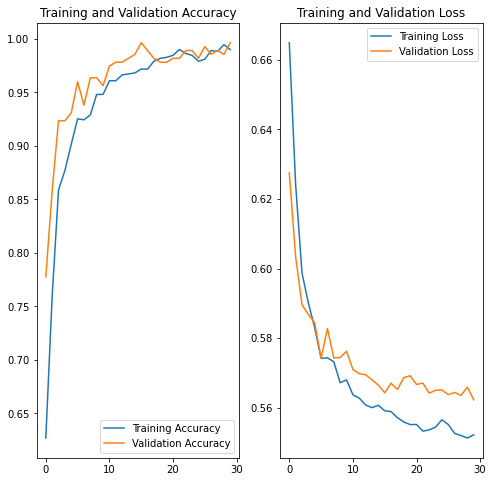

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
# Evaluate the model accuracy on test set 
test_model = keras.models.load_model(
            "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_ds) 
print(f"Test accuracy: {test_acc:.3f}")

2022-01-19 15:55:21.075042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 12s 450ms/step - loss: 0.3363 - accuracy: 0.9236
Test accuracy: 0.924
